# Imports

In [2]:
import os
import ipdb
import argparse
import numpy as np
import pandas as pd
import numpy.random as random
from progressbar import ProgressBar
import matplotlib.pyplot as plt
import gzip
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
import json
pd.options.display.max_columns = 9999999

In [4]:
data = []

with gzip.open('ucimessages_5_injected_H1000.json.gz', 'rt', encoding='utf-16') as f:
    for line in f:
        data.append(json.loads(line))

In [5]:
len(data)

62784

In [6]:
print(data[0])
print(data[1])
print(data[2])
print(data[3])
print(data[4])

{'t': 1082008561, 'u': '1', 'v': '2', 'is_fraud': 0, 'history_type': 'H', 'history_size': 1000, 'bip': False, 'cost': 0.0}
{'t': 1082008561, 'u': '1352', 'v': '1685', 'is_fraud': 1, 'history_type': 'H', 'history_size': 1000, 'bip': False, 'cost': 0.0}
{'t': 1082123439, 'u': '3', 'v': '4', 'is_fraud': 0, 'history_type': 'H', 'history_size': 1000, 'bip': False, 'cost': 0.0}
{'t': 1082381991, 'u': '2', 'v': '5', 'is_fraud': 0, 'history_type': 'H', 'history_size': 1000, 'bip': False, 'cost': 0.0}
{'t': 1082407219, 'u': '6', 'v': '7', 'is_fraud': 0, 'history_type': 'H', 'history_size': 1000, 'bip': False, 'cost': 0.0}


# Flatten the internal `O(1)` features

In [7]:
from utilitiesMe import flatten_dict

In [8]:
# Flattening all rows(
data_flattened = []
for row in data:
    data_flattened.append(flatten_dict(row))

In [9]:
data_flattened[0]

{'t': 1082008561,
 'u': '1',
 'v': '2',
 'is_fraud': 0,
 'history_type': 'H',
 'history_size': 1000,
 'bip': False,
 'cost': 0.0}

# Convert flattened json to dataframe

In [10]:
df = pd.DataFrame.from_dict(data_flattened, orient='columns')

In [11]:
df

,t,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1082008561,1,2,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082008561,1352,1685,1,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082123439,3,4,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1082381991,2,5,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1082407219,6,7,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,1098744248,1847,1899,0,H,1000,False,0.0,362.0,233.0,60.0,1.0,39.0,1.0,181.0,47.0,1.0,103.0,1.0,3.0,24.0,25.0,1.0,44.0,1.0,3.0,24.0,28.0,1.0,106.0,20.0,384.0,1000.0,222.0,60.0,1.0,38.0,1.0,1.0,222.0,162.0
62780,1098744436,1097,1899,0,H,1000,False,0.0,363.0,235.0,59.0,1.0,39.0,1.0,182.0,48.0,1.0,103.0,1.0,1.0,25.0,235.0,1.0,128.0,1.0,1.0,25.0,182.0,2.0,181.0,19.0,384.0,1000.0,222.0,60.0,1.0,38.0,1.0,1.0,222.0,162.0
62781,1098744603,1899,277,0,H,1000,False,0.0,364.0,236.0,59.0,1.0,39.0,1.0,183.0,48.0,1.0,103.0,1.0,1.0,26.0,236.0,1.0,128.0,1.0,1.0,26.0,183.0,2.0,181.0,18.0,385.0,1000.0,223.0,61.0,1.0,38.0,1.0,1.0,223.0,162.0
62782,1098744711,1624,1878,0,H,1000,False,0.0,364.0,236.0,59.0,1.0,39.0,1.0,183.0,48.0,1.0,104.0,1.0,9.0,22.0,2.0,1.0,9.0,2.0,29.0,104.0,1.0,1.0,16.0,0.0,385.0,1000.0,223.0,62.0,1.0,38.0,1.0,11.0,4.0,8.0


In [12]:
df.rename(columns={'t': 'timestamp'}, inplace=True)
df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1082008561,1,2,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082008561,1352,1685,1,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082123439,3,4,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1082381991,2,5,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1082407219,6,7,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,1098744248,1847,1899,0,H,1000,False,0.0,362.0,233.0,60.0,1.0,39.0,1.0,181.0,47.0,1.0,103.0,1.0,3.0,24.0,25.0,1.0,44.0,1.0,3.0,24.0,28.0,1.0,106.0,20.0,384.0,1000.0,222.0,60.0,1.0,38.0,1.0,1.0,222.0,162.0
62780,1098744436,1097,1899,0,H,1000,False,0.0,363.0,235.0,59.0,1.0,39.0,1.0,182.0,48.0,1.0,103.0,1.0,1.0,25.0,235.0,1.0,128.0,1.0,1.0,25.0,182.0,2.0,181.0,19.0,384.0,1000.0,222.0,60.0,1.0,38.0,1.0,1.0,222.0,162.0
62781,1098744603,1899,277,0,H,1000,False,0.0,364.0,236.0,59.0,1.0,39.0,1.0,183.0,48.0,1.0,103.0,1.0,1.0,26.0,236.0,1.0,128.0,1.0,1.0,26.0,183.0,2.0,181.0,18.0,385.0,1000.0,223.0,61.0,1.0,38.0,1.0,1.0,223.0,162.0
62782,1098744711,1624,1878,0,H,1000,False,0.0,364.0,236.0,59.0,1.0,39.0,1.0,183.0,48.0,1.0,104.0,1.0,9.0,22.0,2.0,1.0,9.0,2.0,29.0,104.0,1.0,1.0,16.0,0.0,385.0,1000.0,223.0,62.0,1.0,38.0,1.0,11.0,4.0,8.0


In [13]:
df.describe()

,timestamp,is_fraud,history_size,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,6.278400e+04,62784.000000,62784.0,6.278400e+04,61784.000000,61784.000000,61784.000000,61784.0,61784.000000,61784.000000,61784.000000,61784.000000,61784.0,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000,61784.00000,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000,61784.0,61784.000000,61784.000000,61784.0,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000
mean,1.086024e+09,0.047608,1000.0,2.488691e-07,381.041985,218.451023,69.479768,1.0,33.763126,1.024165,172.855367,53.770102,1.0,109.071070,1.891347,2.918361,9.466383,98.864544,27.794024,92.244400,33.467305,11.189386,32.12466,46.041418,15.722291,95.977891,44.109996,432.470073,1000.0,259.748381,76.231095,1.0,36.516412,1.038295,5.136718,118.103684,94.158730
std,3.186740e+06,0.212936,0.0,6.235848e-05,60.707182,37.138971,18.559320,0.0,24.210497,0.153562,26.279210,15.910696,0.0,56.828584,0.311985,2.326261,11.692340,92.458907,53.719190,59.812743,43.034273,16.499848,46.03282,64.625672,38.248462,74.056657,55.313361,63.300758,0.0,53.526172,17.691013,0.0,19.507709,0.191908,9.391695,120.454680,67.624477
min,1.082009e+09,0.000000,1000.0,0.000000e+00,245.000000,125.000000,32.000000,1.0,10.000000,1.000000,107.000000,19.000000,1.0,32.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,263.000000,1000.0,131.000000,32.000000,1.0,10.000000,1.000000,1.000000,1.000000,0.000000
25%,1.083976e+09,0.000000,1000.0,0.000000e+00,339.000000,187.000000,57.000000,1.0,19.000000,1.000000,154.000000,42.000000,1.0,75.000000,2.000000,1.000000,4.000000,21.000000,2.000000,42.000000,5.000000,2.000000,8.00000,4.000000,1.000000,34.000000,6.000000,396.000000,1000.0,229.000000,63.000000,1.0,24.000000,1.000000,1.000000,12.000000,30.000000
50%,1.085087e+09,0.000000,1000.0,0.000000e+00,379.000000,218.000000,68.000000,1.0,26.000000,1.000000,171.000000,53.000000,1.0,97.000000,2.000000,2.000000,6.000000,61.000000,7.000000,82.000000,17.000000,6.000000,18.00000,14.000000,3.000000,79.000000,23.000000,429.000000,1000.0,259.000000,75.000000,1.0,32.000000,1.000000,2.000000,64.000000,88.000000
75%,1.086349e+09,0.000000,1000.0,0.000000e+00,416.000000,243.000000,80.000000,1.0,37.000000,1.000000,189.000000,63.000000,1.0,119.000000,2.000000,4.000000,11.000000,191.000000,25.000000,141.000000,44.000000,13.000000,39.00000,52.000000,9.000000,150.000000,60.000000,468.000000,1000.0,289.000000,87.000000,1.0,44.000000,1.000000,5.000000,247.000000,163.000000
max,1.098745e+09,1.000000,1000.0,1.562500e-02,580.000000,321.000000,140.000000,1.0,163.000000,2.000000,273.000000,132.000000,1.0,475.000000,3.000000,36.000000,163.000000,321.000000,319.000000,272.000000,269.000000,197.000000,475.00000,271.000000,270.000000,360.000000,360.000000,618.000000,1000.0,437.000000,137.000000,1.0,173.000000,2.000000,173.000000,437.000000,231.000000


# Remove NaNs

In [14]:
df.head(10)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1082008561,1,2,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082008561,1352,1685,1,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082123439,3,4,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1082381991,2,5,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1082407219,6,7,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1082407356,7,8,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1082408003,10,9,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1082408053,11,9,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1082408788,12,13,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1082409354,14,9,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Create a new DataFrame to preserve rows with NaN
nan_df = pd.DataFrame(columns=df.columns)

# Remove rows with NaN from 'df' and append them to 'nan_df'
nan_rows = df[df.isnull().any(axis=1)]
df = df.dropna()
nan_df = nan_df.append(nan_rows)

# Display the updated 'df' and 'nan_df'
print("Updated DataFrame without NaN:")
df

Updated DataFrame without NaN:


,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
1000,1082842403,132,3,0,H,1000,False,0.0,313.0,158.0,58.0,1.0,42.0,1.0,147.0,42.0,1.0,132.0,2.0,5.0,7.0,9.0,8.0,45.0,27.0,6.0,12.0,6.0,2.0,63.0,38.0,522.0,1000.0,361.0,76.0,1.0,31.0,1.0,1.0,361.0,161.0
1001,1082842765,1,30,0,H,1000,False,0.0,312.0,158.0,57.0,1.0,42.0,1.0,147.0,41.0,1.0,132.0,2.0,4.0,4.0,16.0,16.0,54.0,54.0,4.0,10.0,16.0,4.0,88.0,44.0,522.0,1000.0,361.0,76.0,1.0,31.0,1.0,1.0,361.0,161.0
1002,1082843254,32,41,0,H,1000,False,0.0,311.0,157.0,57.0,1.0,42.0,1.0,146.0,41.0,1.0,133.0,2.0,28.0,42.0,1.0,1.0,5.0,0.0,76.0,133.0,1.0,1.0,3.0,0.0,521.0,1000.0,360.0,75.0,1.0,31.0,1.0,3.0,30.0,56.0
1003,1082843266,173,41,0,H,1000,False,0.0,309.0,154.0,58.0,1.0,43.0,2.0,143.0,42.0,1.0,134.0,2.0,2.0,43.0,58.0,1.0,97.0,0.0,2.0,134.0,42.0,1.0,124.0,0.0,521.0,1000.0,360.0,75.0,1.0,31.0,1.0,1.0,360.0,161.0
1004,1082844039,103,166,0,H,1000,False,0.0,309.0,154.0,60.0,1.0,43.0,2.0,143.0,44.0,1.0,134.0,2.0,4.0,32.0,17.0,1.0,54.0,4.0,5.0,83.0,20.0,1.0,69.0,2.0,521.0,1000.0,360.0,75.0,1.0,31.0,1.0,1.0,360.0,161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,1098744248,1847,1899,0,H,1000,False,0.0,362.0,233.0,60.0,1.0,39.0,1.0,181.0,47.0,1.0,103.0,1.0,3.0,24.0,25.0,1.0,44.0,1.0,3.0,24.0,28.0,1.0,106.0,20.0,384.0,1000.0,222.0,60.0,1.0,38.0,1.0,1.0,222.0,162.0
62780,1098744436,1097,1899,0,H,1000,False,0.0,363.0,235.0,59.0,1.0,39.0,1.0,182.0,48.0,1.0,103.0,1.0,1.0,25.0,235.0,1.0,128.0,1.0,1.0,25.0,182.0,2.0,181.0,19.0,384.0,1000.0,222.0,60.0,1.0,38.0,1.0,1.0,222.0,162.0
62781,1098744603,1899,277,0,H,1000,False,0.0,364.0,236.0,59.0,1.0,39.0,1.0,183.0,48.0,1.0,103.0,1.0,1.0,26.0,236.0,1.0,128.0,1.0,1.0,26.0,183.0,2.0,181.0,18.0,385.0,1000.0,223.0,61.0,1.0,38.0,1.0,1.0,223.0,162.0
62782,1098744711,1624,1878,0,H,1000,False,0.0,364.0,236.0,59.0,1.0,39.0,1.0,183.0,48.0,1.0,104.0,1.0,9.0,22.0,2.0,1.0,9.0,2.0,29.0,104.0,1.0,1.0,16.0,0.0,385.0,1000.0,223.0,62.0,1.0,38.0,1.0,11.0,4.0,8.0


In [16]:
nan_df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1082008561,1,2,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082008561,1352,1685,1,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082123439,3,4,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1082381991,2,5,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1082407219,6,7,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1082840223,185,69,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,1082841461,166,41,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,1082841524,304,719,1,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,1082841524,32,41,0,H,1000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df.describe()

,timestamp,is_fraud,history_size,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,6.178400e+04,61784.000000,61784.0,6.178400e+04,61784.000000,61784.000000,61784.000000,61784.0,61784.000000,61784.000000,61784.000000,61784.000000,61784.0,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000,61784.00000,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000,61784.0,61784.000000,61784.000000,61784.0,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000
mean,1.086077e+09,0.047666,1000.0,2.528972e-07,381.041985,218.451023,69.479768,1.0,33.763126,1.024165,172.855367,53.770102,1.0,109.071070,1.891347,2.918361,9.466383,98.864544,27.794024,92.244400,33.467305,11.189386,32.12466,46.041418,15.722291,95.977891,44.109996,432.470073,1000.0,259.748381,76.231095,1.0,36.516412,1.038295,5.136718,118.103684,94.158730
std,3.184132e+06,0.213060,0.0,6.286111e-05,60.707182,37.138971,18.559320,0.0,24.210497,0.153562,26.279210,15.910696,0.0,56.828584,0.311985,2.326261,11.692340,92.458907,53.719190,59.812743,43.034273,16.499848,46.03282,64.625672,38.248462,74.056657,55.313361,63.300758,0.0,53.526172,17.691013,0.0,19.507709,0.191908,9.391695,120.454680,67.624477
min,1.082842e+09,0.000000,1000.0,0.000000e+00,245.000000,125.000000,32.000000,1.0,10.000000,1.000000,107.000000,19.000000,1.0,32.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,263.000000,1000.0,131.000000,32.000000,1.0,10.000000,1.000000,1.000000,1.000000,0.000000
25%,1.084037e+09,0.000000,1000.0,0.000000e+00,339.000000,187.000000,57.000000,1.0,19.000000,1.000000,154.000000,42.000000,1.0,75.000000,2.000000,1.000000,4.000000,21.000000,2.000000,42.000000,5.000000,2.000000,8.00000,4.000000,1.000000,34.000000,6.000000,396.000000,1000.0,229.000000,63.000000,1.0,24.000000,1.000000,1.000000,12.000000,30.000000
50%,1.085103e+09,0.000000,1000.0,0.000000e+00,379.000000,218.000000,68.000000,1.0,26.000000,1.000000,171.000000,53.000000,1.0,97.000000,2.000000,2.000000,6.000000,61.000000,7.000000,82.000000,17.000000,6.000000,18.00000,14.000000,3.000000,79.000000,23.000000,429.000000,1000.0,259.000000,75.000000,1.0,32.000000,1.000000,2.000000,64.000000,88.000000
75%,1.086401e+09,0.000000,1000.0,0.000000e+00,416.000000,243.000000,80.000000,1.0,37.000000,1.000000,189.000000,63.000000,1.0,119.000000,2.000000,4.000000,11.000000,191.000000,25.000000,141.000000,44.000000,13.000000,39.00000,52.000000,9.000000,150.000000,60.000000,468.000000,1000.0,289.000000,87.000000,1.0,44.000000,1.000000,5.000000,247.000000,163.000000
max,1.098745e+09,1.000000,1000.0,1.562500e-02,580.000000,321.000000,140.000000,1.0,163.000000,2.000000,273.000000,132.000000,1.0,475.000000,3.000000,36.000000,163.000000,321.000000,319.000000,272.000000,269.000000,197.000000,475.00000,271.000000,270.000000,360.000000,360.000000,618.000000,1000.0,437.000000,137.000000,1.0,173.000000,2.000000,173.000000,437.000000,231.000000


In [18]:
df_features = df.drop(["timestamp",
                       "u",
                       "v", 
                        "history_type", 
                        "bip", 
                        "cost", # cost of O1 features
                        "history_size"], axis="columns")
df_features

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
1000,0,313.0,158.0,58.0,1.0,42.0,1.0,147.0,42.0,1.0,132.0,2.0,5.0,7.0,9.0,8.0,45.0,27.0,6.0,12.0,6.0,2.0,63.0,38.0,522.0,1000.0,361.0,76.0,1.0,31.0,1.0,1.0,361.0,161.0
1001,0,312.0,158.0,57.0,1.0,42.0,1.0,147.0,41.0,1.0,132.0,2.0,4.0,4.0,16.0,16.0,54.0,54.0,4.0,10.0,16.0,4.0,88.0,44.0,522.0,1000.0,361.0,76.0,1.0,31.0,1.0,1.0,361.0,161.0
1002,0,311.0,157.0,57.0,1.0,42.0,1.0,146.0,41.0,1.0,133.0,2.0,28.0,42.0,1.0,1.0,5.0,0.0,76.0,133.0,1.0,1.0,3.0,0.0,521.0,1000.0,360.0,75.0,1.0,31.0,1.0,3.0,30.0,56.0
1003,0,309.0,154.0,58.0,1.0,43.0,2.0,143.0,42.0,1.0,134.0,2.0,2.0,43.0,58.0,1.0,97.0,0.0,2.0,134.0,42.0,1.0,124.0,0.0,521.0,1000.0,360.0,75.0,1.0,31.0,1.0,1.0,360.0,161.0
1004,0,309.0,154.0,60.0,1.0,43.0,2.0,143.0,44.0,1.0,134.0,2.0,4.0,32.0,17.0,1.0,54.0,4.0,5.0,83.0,20.0,1.0,69.0,2.0,521.0,1000.0,360.0,75.0,1.0,31.0,1.0,1.0,360.0,161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,0,362.0,233.0,60.0,1.0,39.0,1.0,181.0,47.0,1.0,103.0,1.0,3.0,24.0,25.0,1.0,44.0,1.0,3.0,24.0,28.0,1.0,106.0,20.0,384.0,1000.0,222.0,60.0,1.0,38.0,1.0,1.0,222.0,162.0
62780,0,363.0,235.0,59.0,1.0,39.0,1.0,182.0,48.0,1.0,103.0,1.0,1.0,25.0,235.0,1.0,128.0,1.0,1.0,25.0,182.0,2.0,181.0,19.0,384.0,1000.0,222.0,60.0,1.0,38.0,1.0,1.0,222.0,162.0
62781,0,364.0,236.0,59.0,1.0,39.0,1.0,183.0,48.0,1.0,103.0,1.0,1.0,26.0,236.0,1.0,128.0,1.0,1.0,26.0,183.0,2.0,181.0,18.0,385.0,1000.0,223.0,61.0,1.0,38.0,1.0,1.0,223.0,162.0
62782,0,364.0,236.0,59.0,1.0,39.0,1.0,183.0,48.0,1.0,104.0,1.0,9.0,22.0,2.0,1.0,9.0,2.0,29.0,104.0,1.0,1.0,16.0,0.0,385.0,1000.0,223.0,62.0,1.0,38.0,1.0,11.0,4.0,8.0


In [19]:
df_features.describe()

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,61784.000000,61784.000000,61784.000000,61784.000000,61784.0,61784.000000,61784.000000,61784.000000,61784.000000,61784.0,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000,61784.00000,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000,61784.0,61784.000000,61784.000000,61784.0,61784.000000,61784.000000,61784.000000,61784.000000,61784.000000
mean,0.047666,381.041985,218.451023,69.479768,1.0,33.763126,1.024165,172.855367,53.770102,1.0,109.071070,1.891347,2.918361,9.466383,98.864544,27.794024,92.244400,33.467305,11.189386,32.12466,46.041418,15.722291,95.977891,44.109996,432.470073,1000.0,259.748381,76.231095,1.0,36.516412,1.038295,5.136718,118.103684,94.158730
std,0.213060,60.707182,37.138971,18.559320,0.0,24.210497,0.153562,26.279210,15.910696,0.0,56.828584,0.311985,2.326261,11.692340,92.458907,53.719190,59.812743,43.034273,16.499848,46.03282,64.625672,38.248462,74.056657,55.313361,63.300758,0.0,53.526172,17.691013,0.0,19.507709,0.191908,9.391695,120.454680,67.624477
min,0.000000,245.000000,125.000000,32.000000,1.0,10.000000,1.000000,107.000000,19.000000,1.0,32.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,263.000000,1000.0,131.000000,32.000000,1.0,10.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,339.000000,187.000000,57.000000,1.0,19.000000,1.000000,154.000000,42.000000,1.0,75.000000,2.000000,1.000000,4.000000,21.000000,2.000000,42.000000,5.000000,2.000000,8.00000,4.000000,1.000000,34.000000,6.000000,396.000000,1000.0,229.000000,63.000000,1.0,24.000000,1.000000,1.000000,12.000000,30.000000
50%,0.000000,379.000000,218.000000,68.000000,1.0,26.000000,1.000000,171.000000,53.000000,1.0,97.000000,2.000000,2.000000,6.000000,61.000000,7.000000,82.000000,17.000000,6.000000,18.00000,14.000000,3.000000,79.000000,23.000000,429.000000,1000.0,259.000000,75.000000,1.0,32.000000,1.000000,2.000000,64.000000,88.000000
75%,0.000000,416.000000,243.000000,80.000000,1.0,37.000000,1.000000,189.000000,63.000000,1.0,119.000000,2.000000,4.000000,11.000000,191.000000,25.000000,141.000000,44.000000,13.000000,39.00000,52.000000,9.000000,150.000000,60.000000,468.000000,1000.0,289.000000,87.000000,1.0,44.000000,1.000000,5.000000,247.000000,163.000000
max,1.000000,580.000000,321.000000,140.000000,1.0,163.000000,2.000000,273.000000,132.000000,1.0,475.000000,3.000000,36.000000,163.000000,321.000000,319.000000,272.000000,269.000000,197.000000,475.00000,271.000000,270.000000,360.000000,360.000000,618.000000,1000.0,437.000000,137.000000,1.0,173.000000,2.000000,173.000000,437.000000,231.000000


In [20]:
df_target = df["is_fraud"]
df_target

1000     0
1001     0
1002     0
1003     0
1004     0
        ..
62779    0
62780    0
62781    0
62782    0
62783    0
Name: is_fraud, Length: 61784, dtype: int64

# Learning Technique #1: Classical + Underasmpling in training only

## $r$ = 0.7
Before undersampling, take 30% for testing then the 70% take it for training and do undersampling on it

In [21]:
percentage=round(len(df)/100*70) 
train_df=df_features.head(percentage)
test_df=df_features.iloc[percentage:len(df_features),:]

In [22]:
len(train_df) + len(test_df) == len(df)

True

In [23]:
train_df

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
1000,0,313.0,158.0,58.0,1.0,42.0,1.0,147.0,42.0,1.0,132.0,2.0,5.0,7.0,9.0,8.0,45.0,27.0,6.0,12.0,6.0,2.0,63.0,38.0,522.0,1000.0,361.0,76.0,1.0,31.0,1.0,1.0,361.0,161.0
1001,0,312.0,158.0,57.0,1.0,42.0,1.0,147.0,41.0,1.0,132.0,2.0,4.0,4.0,16.0,16.0,54.0,54.0,4.0,10.0,16.0,4.0,88.0,44.0,522.0,1000.0,361.0,76.0,1.0,31.0,1.0,1.0,361.0,161.0
1002,0,311.0,157.0,57.0,1.0,42.0,1.0,146.0,41.0,1.0,133.0,2.0,28.0,42.0,1.0,1.0,5.0,0.0,76.0,133.0,1.0,1.0,3.0,0.0,521.0,1000.0,360.0,75.0,1.0,31.0,1.0,3.0,30.0,56.0
1003,0,309.0,154.0,58.0,1.0,43.0,2.0,143.0,42.0,1.0,134.0,2.0,2.0,43.0,58.0,1.0,97.0,0.0,2.0,134.0,42.0,1.0,124.0,0.0,521.0,1000.0,360.0,75.0,1.0,31.0,1.0,1.0,360.0,161.0
1004,0,309.0,154.0,60.0,1.0,43.0,2.0,143.0,44.0,1.0,134.0,2.0,4.0,32.0,17.0,1.0,54.0,4.0,5.0,83.0,20.0,1.0,69.0,2.0,521.0,1000.0,360.0,75.0,1.0,31.0,1.0,1.0,360.0,161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44244,0,534.0,275.0,121.0,1.0,26.0,1.0,217.0,85.0,1.0,41.0,2.0,4.0,7.0,38.0,5.0,52.0,16.0,5.0,12.0,30.0,6.0,96.0,28.0,597.0,1000.0,409.0,106.0,1.0,21.0,1.0,1.0,409.0,188.0
44245,0,534.0,274.0,122.0,1.0,26.0,1.0,217.0,85.0,1.0,41.0,2.0,2.0,8.0,122.0,4.0,138.0,13.0,2.0,13.0,85.0,5.0,232.0,24.0,598.0,1000.0,411.0,105.0,1.0,21.0,1.0,1.0,411.0,187.0
44246,0,534.0,274.0,122.0,1.0,26.0,1.0,217.0,84.0,1.0,41.0,2.0,2.0,8.0,122.0,4.0,138.0,13.0,3.0,14.0,68.0,5.0,165.0,20.0,598.0,1000.0,410.0,106.0,1.0,21.0,1.0,2.0,106.0,82.0
44247,0,533.0,273.0,123.0,1.0,26.0,1.0,216.0,85.0,1.0,41.0,2.0,2.0,8.0,123.0,4.0,137.0,13.0,5.0,15.0,31.0,4.0,96.0,17.0,597.0,1000.0,409.0,106.0,1.0,21.0,1.0,4.0,12.0,26.0


In [24]:
test_df

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
44249,0,534.0,274.0,123.0,1.0,26.0,1.0,217.0,85.0,1.0,41.0,2.0,2.0,9.0,123.0,6.0,137.0,8.0,4.0,16.0,40.0,4.0,126.0,14.0,597.0,1000.0,409.0,106.0,1.0,21.0,1.0,2.0,106.0,82.0
44250,1,536.0,277.0,123.0,1.0,26.0,1.0,220.0,84.0,1.0,41.0,2.0,1.0,1.0,277.0,277.0,259.0,259.0,1.0,1.0,220.0,220.0,316.0,316.0,597.0,1000.0,409.0,106.0,1.0,21.0,1.0,1.0,409.0,188.0
44251,0,536.0,277.0,124.0,1.0,26.0,1.0,220.0,84.0,1.0,41.0,2.0,2.0,9.0,124.0,6.0,135.0,8.0,5.0,17.0,31.0,1.0,96.0,14.0,596.0,1000.0,408.0,105.0,1.0,21.0,1.0,3.0,45.0,38.0
44252,0,535.0,277.0,123.0,1.0,26.0,1.0,220.0,83.0,1.0,41.0,2.0,2.0,9.0,123.0,6.0,135.0,8.0,6.0,18.0,18.0,3.0,79.0,12.0,595.0,1000.0,407.0,105.0,1.0,21.0,1.0,4.0,13.0,26.0
44253,1,537.0,279.0,123.0,1.0,26.0,1.0,222.0,83.0,1.0,41.0,2.0,1.0,1.0,279.0,279.0,258.0,258.0,1.0,1.0,222.0,222.0,315.0,315.0,596.0,1000.0,408.0,105.0,1.0,21.0,1.0,1.0,408.0,188.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,0,362.0,233.0,60.0,1.0,39.0,1.0,181.0,47.0,1.0,103.0,1.0,3.0,24.0,25.0,1.0,44.0,1.0,3.0,24.0,28.0,1.0,106.0,20.0,384.0,1000.0,222.0,60.0,1.0,38.0,1.0,1.0,222.0,162.0
62780,0,363.0,235.0,59.0,1.0,39.0,1.0,182.0,48.0,1.0,103.0,1.0,1.0,25.0,235.0,1.0,128.0,1.0,1.0,25.0,182.0,2.0,181.0,19.0,384.0,1000.0,222.0,60.0,1.0,38.0,1.0,1.0,222.0,162.0
62781,0,364.0,236.0,59.0,1.0,39.0,1.0,183.0,48.0,1.0,103.0,1.0,1.0,26.0,236.0,1.0,128.0,1.0,1.0,26.0,183.0,2.0,181.0,18.0,385.0,1000.0,223.0,61.0,1.0,38.0,1.0,1.0,223.0,162.0
62782,0,364.0,236.0,59.0,1.0,39.0,1.0,183.0,48.0,1.0,104.0,1.0,9.0,22.0,2.0,1.0,9.0,2.0,29.0,104.0,1.0,1.0,16.0,0.0,385.0,1000.0,223.0,62.0,1.0,38.0,1.0,11.0,4.0,8.0


### Undersampling and training on `X_train, y_train`

In [25]:
train_df["is_fraud"].value_counts()

0    41175
1     2074
Name: is_fraud, dtype: int64

In [26]:
# Separating the data for analysis (they will be Series)
nonanomalous = train_df[train_df.is_fraud == 0]
anomalous = train_df[train_df.is_fraud == 1]

In [27]:
print(len(nonanomalous))
print(len(anomalous))

41175
2074


In [28]:
print(nonanomalous.shape)
print(anomalous.shape)

(41175, 34)
(2074, 34)


In [29]:
# Compare the values for both classes
train_df.groupby("is_fraud").mean()

,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,374.383971,208.880801,67.655713,1.0,31.922866,1.034244,170.385574,51.873661,1.0,96.857851,1.889812,3.106715,9.311475,85.839927,19.622635,89.264772,28.940255,11.240510,28.474026,38.323109,9.703145,88.843934,37.516017,440.302829,1000.0,270.371560,76.381785,1.0,35.630917,1.0,4.86844,115.769083,90.050468
1,376.690935,210.715526,67.592093,1.0,32.090646,1.027483,172.277242,51.973481,1.0,96.156702,1.882835,1.059788,1.836548,203.880424,152.786403,162.191900,132.001929,1.097878,2.861138,166.379942,122.703472,200.731919,169.730955,442.592093,1000.0,272.413211,76.475410,1.0,35.115236,1.0,1.00000,272.413211,170.178881


In [30]:
# Sampling
nonanomalous_sample = nonanomalous.sample(n = len(anomalous), random_state=12)

In [31]:
# Concatenating
new_dataset = pd.concat([nonanomalous_sample, anomalous], axis=0)

In [32]:
new_dataset

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
27915,0,398.0,224.0,75.0,1.0,21.0,1.0,175.0,54.0,1.0,68.0,2.0,2.0,5.0,75.0,16.0,99.0,24.0,2.0,8.0,54.0,11.0,169.0,56.0,429.0,1000.0,249.0,86.0,1.0,55.0,1.0,1.0,249.0,180.0
25014,0,368.0,209.0,66.0,1.0,24.0,1.0,180.0,41.0,1.0,66.0,2.0,6.0,6.0,9.0,9.0,22.0,22.0,25.0,9.0,2.0,4.0,17.0,52.0,420.0,1000.0,264.0,70.0,1.0,37.0,1.0,2.0,70.0,86.0
7993,0,307.0,178.0,52.0,1.0,17.0,1.0,143.0,39.0,1.0,129.0,2.0,1.0,3.0,178.0,22.0,129.0,55.0,3.0,6.0,27.0,13.0,98.0,58.0,370.0,1000.0,211.0,69.0,1.0,80.0,1.0,3.0,29.0,61.0
30967,0,406.0,233.0,68.0,1.0,17.0,1.0,180.0,66.0,1.0,101.0,2.0,4.0,12.0,27.0,2.0,34.0,3.0,10.0,46.0,7.0,1.0,50.0,2.0,438.0,1000.0,264.0,85.0,1.0,22.0,1.0,3.0,26.0,63.0
24241,0,418.0,241.0,74.0,1.0,65.0,1.0,200.0,57.0,1.0,82.0,2.0,2.0,3.0,74.0,30.0,103.0,73.0,2.0,4.0,57.0,31.0,161.0,95.0,505.0,1000.0,331.0,82.0,1.0,31.0,1.0,1.0,331.0,174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44158,1,529.0,274.0,119.0,1.0,25.0,1.0,219.0,84.0,1.0,48.0,2.0,1.0,1.0,274.0,274.0,255.0,255.0,1.0,1.0,219.0,219.0,310.0,310.0,584.0,1000.0,400.0,96.0,1.0,21.0,1.0,1.0,400.0,184.0
44163,1,530.0,274.0,121.0,1.0,25.0,1.0,219.0,85.0,1.0,48.0,2.0,1.0,1.0,274.0,274.0,256.0,256.0,1.0,1.0,219.0,219.0,311.0,311.0,584.0,1000.0,400.0,97.0,1.0,21.0,1.0,1.0,400.0,184.0
44164,1,529.0,272.0,123.0,1.0,25.0,1.0,217.0,86.0,1.0,48.0,2.0,2.0,6.0,123.0,14.0,134.0,18.0,2.0,9.0,86.0,9.0,226.0,39.0,584.0,1000.0,400.0,97.0,1.0,21.0,1.0,1.0,400.0,184.0
44189,1,536.0,277.0,125.0,1.0,25.0,1.0,221.0,88.0,1.0,48.0,2.0,1.0,2.0,277.0,125.0,259.0,134.0,1.0,5.0,221.0,34.0,315.0,97.0,592.0,1000.0,409.0,100.0,1.0,21.0,1.0,1.0,409.0,183.0


Author: Now the rows of the `nonanomalous` are random

In [33]:
# Now we will check deeper the values on the new dataset and compare them
new_dataset["is_fraud"].value_counts()

0    2074
1    2074
Name: is_fraud, dtype: int64

In [34]:
new_dataset.groupby("is_fraud").mean()

,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,375.310029,209.641755,67.974446,1.0,33.108486,1.036162,171.158149,51.976374,1.0,97.704918,1.885728,3.064609,9.655256,87.918033,18.430569,90.440694,28.484571,11.255063,29.051109,38.920926,8.947445,90.009643,36.917068,441.608004,1000.0,271.718901,76.493732,1.0,35.715526,1.0,4.86837,118.224687,90.877049
1,376.690935,210.715526,67.592093,1.0,32.090646,1.027483,172.277242,51.973481,1.0,96.156702,1.882835,1.059788,1.836548,203.880424,152.786403,162.191900,132.001929,1.097878,2.861138,166.379942,122.703472,200.731919,169.730955,442.592093,1000.0,272.413211,76.475410,1.0,35.115236,1.0,1.00000,272.413211,170.178881


In [35]:
new_dataset

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
27915,0,398.0,224.0,75.0,1.0,21.0,1.0,175.0,54.0,1.0,68.0,2.0,2.0,5.0,75.0,16.0,99.0,24.0,2.0,8.0,54.0,11.0,169.0,56.0,429.0,1000.0,249.0,86.0,1.0,55.0,1.0,1.0,249.0,180.0
25014,0,368.0,209.0,66.0,1.0,24.0,1.0,180.0,41.0,1.0,66.0,2.0,6.0,6.0,9.0,9.0,22.0,22.0,25.0,9.0,2.0,4.0,17.0,52.0,420.0,1000.0,264.0,70.0,1.0,37.0,1.0,2.0,70.0,86.0
7993,0,307.0,178.0,52.0,1.0,17.0,1.0,143.0,39.0,1.0,129.0,2.0,1.0,3.0,178.0,22.0,129.0,55.0,3.0,6.0,27.0,13.0,98.0,58.0,370.0,1000.0,211.0,69.0,1.0,80.0,1.0,3.0,29.0,61.0
30967,0,406.0,233.0,68.0,1.0,17.0,1.0,180.0,66.0,1.0,101.0,2.0,4.0,12.0,27.0,2.0,34.0,3.0,10.0,46.0,7.0,1.0,50.0,2.0,438.0,1000.0,264.0,85.0,1.0,22.0,1.0,3.0,26.0,63.0
24241,0,418.0,241.0,74.0,1.0,65.0,1.0,200.0,57.0,1.0,82.0,2.0,2.0,3.0,74.0,30.0,103.0,73.0,2.0,4.0,57.0,31.0,161.0,95.0,505.0,1000.0,331.0,82.0,1.0,31.0,1.0,1.0,331.0,174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44158,1,529.0,274.0,119.0,1.0,25.0,1.0,219.0,84.0,1.0,48.0,2.0,1.0,1.0,274.0,274.0,255.0,255.0,1.0,1.0,219.0,219.0,310.0,310.0,584.0,1000.0,400.0,96.0,1.0,21.0,1.0,1.0,400.0,184.0
44163,1,530.0,274.0,121.0,1.0,25.0,1.0,219.0,85.0,1.0,48.0,2.0,1.0,1.0,274.0,274.0,256.0,256.0,1.0,1.0,219.0,219.0,311.0,311.0,584.0,1000.0,400.0,97.0,1.0,21.0,1.0,1.0,400.0,184.0
44164,1,529.0,272.0,123.0,1.0,25.0,1.0,217.0,86.0,1.0,48.0,2.0,2.0,6.0,123.0,14.0,134.0,18.0,2.0,9.0,86.0,9.0,226.0,39.0,584.0,1000.0,400.0,97.0,1.0,21.0,1.0,1.0,400.0,184.0
44189,1,536.0,277.0,125.0,1.0,25.0,1.0,221.0,88.0,1.0,48.0,2.0,1.0,2.0,277.0,125.0,259.0,134.0,1.0,5.0,221.0,34.0,315.0,97.0,592.0,1000.0,409.0,100.0,1.0,21.0,1.0,1.0,409.0,183.0


In [36]:
# Assuming 'df' is your DataFrame
new_dataset = new_dataset.sample(frac=1, random_state=42)  # frac=1 means we sample 100% of the data
new_dataset

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
16995,0,415.0,255.0,65.0,1.0,88.0,1.0,213.0,58.0,1.0,116.0,1.0,1.0,9.0,255.0,1.0,160.0,8.0,7.0,31.0,14.0,1.0,54.0,11.0,487.0,1000.0,320.0,91.0,1.0,59.0,1.0,7.0,4.0,14.0
6375,0,307.0,174.0,53.0,1.0,24.0,1.0,160.0,38.0,1.0,97.0,1.0,1.0,8.0,174.0,3.0,133.0,16.0,1.0,22.0,160.0,1.0,147.0,24.0,386.0,1000.0,260.0,50.0,1.0,44.0,1.0,1.0,260.0,126.0
42778,0,447.0,272.0,87.0,1.0,37.0,1.0,214.0,73.0,1.0,119.0,2.0,1.0,37.0,272.0,1.0,175.0,0.0,3.0,59.0,33.0,1.0,127.0,2.0,463.0,1000.0,290.0,82.0,1.0,31.0,1.0,3.0,32.0,59.0
32018,0,401.0,240.0,78.0,1.0,19.0,1.0,191.0,56.0,1.0,179.0,2.0,1.0,6.0,240.0,11.0,161.0,12.0,1.0,9.0,191.0,4.0,210.0,49.0,403.0,1000.0,246.0,68.0,1.0,54.0,1.0,1.0,246.0,157.0
24416,0,383.0,221.0,61.0,1.0,25.0,1.0,175.0,55.0,1.0,65.0,2.0,1.0,7.0,221.0,7.0,162.0,18.0,1.0,45.0,175.0,1.0,208.0,4.0,451.0,1000.0,270.0,87.0,1.0,34.0,1.0,1.0,270.0,181.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29284,1,401.0,215.0,78.0,1.0,29.0,1.0,169.0,59.0,1.0,102.0,2.0,1.0,1.0,215.0,215.0,186.0,186.0,1.0,1.0,169.0,169.0,232.0,232.0,450.0,1000.0,258.0,96.0,1.0,23.0,1.0,1.0,258.0,192.0
2353,0,281.0,152.0,37.0,1.0,23.0,1.0,140.0,26.0,1.0,86.0,2.0,3.0,14.0,23.0,2.0,69.0,5.0,12.0,50.0,7.0,1.0,48.0,6.0,415.0,1000.0,248.0,66.0,1.0,28.0,1.0,9.0,6.0,15.0
22381,1,398.0,224.0,73.0,1.0,27.0,1.0,167.0,60.0,1.0,108.0,2.0,1.0,1.0,224.0,224.0,174.0,174.0,1.0,1.0,167.0,167.0,231.0,231.0,443.0,1000.0,254.0,96.0,1.0,60.0,1.0,1.0,254.0,189.0
36128,1,419.0,231.0,84.0,1.0,55.0,1.0,177.0,54.0,1.0,163.0,2.0,1.0,1.0,231.0,231.0,188.0,188.0,1.0,1.0,177.0,177.0,242.0,242.0,461.0,1000.0,272.0,94.0,1.0,24.0,1.0,1.0,272.0,189.0


In [37]:
# Specify the features (X) and the target variable (y)
X_train = new_dataset.drop('is_fraud', axis=1)
y_train = new_dataset['is_fraud']

rf_classifier = RandomForestClassifier(random_state=42)

rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Testing on `X_test, y_test`

In [38]:
test_df["is_fraud"].value_counts()

0    17664
1      871
Name: is_fraud, dtype: int64

In [39]:
test_df.groupby("is_fraud").mean()

,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,396.080163,240.427197,73.694237,1.0,38.011549,1.001472,178.263983,58.140625,1.0,137.725260,1.896626,2.789855,11.097600,110.083503,25.124321,87.915648,28.227412,12.752491,45.508152,43.494962,11.741225,94.359545,38.185575,413.723336,1000.0,234.541837,75.823539,1.0,38.677140,1.128963,6.451710,99.497000,90.595675
1,401.172216,243.606200,74.733639,1.0,38.582090,1.000000,181.299656,59.064294,1.0,136.070034,1.877153,1.045924,1.876005,236.997704,170.595867,154.331803,119.113662,1.102181,2.964409,176.006889,126.262916,216.606200,176.851894,418.274397,1000.0,238.591274,76.791045,1.0,37.893226,1.101033,1.001148,238.376579,179.611940


In [40]:
# Specify the features (X) and the target variable (y)
X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

In [41]:
test_df["is_fraud"].value_counts()

0    17664
1      871
Name: is_fraud, dtype: int64

In [42]:
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])

print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9635


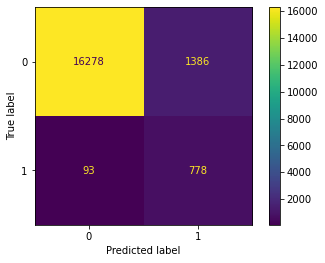

In [43]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
disp.plot()

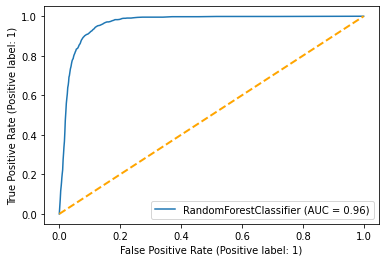

In [44]:
from sklearn.metrics import RocCurveDisplay
rfc_disp = RocCurveDisplay.from_estimator(rf_classifier, X_test, y_test)
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')

# Learning Technique #2: Sliding window with undersampling in training only

In [45]:
df.reset_index(drop=True, inplace=True)

In [46]:
# Specify the features (X) and the target variable (y)
X = df.drop(["timestamp", 
             "u", 
             "v", 
             "history_type", 
             "bip", 
             "cost", # cost of O1 features
             "history_size",
             "is_fraud",], axis="columns")
y = df["is_fraud"]

In [47]:
X

,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,313.0,158.0,58.0,1.0,42.0,1.0,147.0,42.0,1.0,132.0,2.0,5.0,7.0,9.0,8.0,45.0,27.0,6.0,12.0,6.0,2.0,63.0,38.0,522.0,1000.0,361.0,76.0,1.0,31.0,1.0,1.0,361.0,161.0
1,312.0,158.0,57.0,1.0,42.0,1.0,147.0,41.0,1.0,132.0,2.0,4.0,4.0,16.0,16.0,54.0,54.0,4.0,10.0,16.0,4.0,88.0,44.0,522.0,1000.0,361.0,76.0,1.0,31.0,1.0,1.0,361.0,161.0
2,311.0,157.0,57.0,1.0,42.0,1.0,146.0,41.0,1.0,133.0,2.0,28.0,42.0,1.0,1.0,5.0,0.0,76.0,133.0,1.0,1.0,3.0,0.0,521.0,1000.0,360.0,75.0,1.0,31.0,1.0,3.0,30.0,56.0
3,309.0,154.0,58.0,1.0,43.0,2.0,143.0,42.0,1.0,134.0,2.0,2.0,43.0,58.0,1.0,97.0,0.0,2.0,134.0,42.0,1.0,124.0,0.0,521.0,1000.0,360.0,75.0,1.0,31.0,1.0,1.0,360.0,161.0
4,309.0,154.0,60.0,1.0,43.0,2.0,143.0,44.0,1.0,134.0,2.0,4.0,32.0,17.0,1.0,54.0,4.0,5.0,83.0,20.0,1.0,69.0,2.0,521.0,1000.0,360.0,75.0,1.0,31.0,1.0,1.0,360.0,161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61779,362.0,233.0,60.0,1.0,39.0,1.0,181.0,47.0,1.0,103.0,1.0,3.0,24.0,25.0,1.0,44.0,1.0,3.0,24.0,28.0,1.0,106.0,20.0,384.0,1000.0,222.0,60.0,1.0,38.0,1.0,1.0,222.0,162.0
61780,363.0,235.0,59.0,1.0,39.0,1.0,182.0,48.0,1.0,103.0,1.0,1.0,25.0,235.0,1.0,128.0,1.0,1.0,25.0,182.0,2.0,181.0,19.0,384.0,1000.0,222.0,60.0,1.0,38.0,1.0,1.0,222.0,162.0
61781,364.0,236.0,59.0,1.0,39.0,1.0,183.0,48.0,1.0,103.0,1.0,1.0,26.0,236.0,1.0,128.0,1.0,1.0,26.0,183.0,2.0,181.0,18.0,385.0,1000.0,223.0,61.0,1.0,38.0,1.0,1.0,223.0,162.0
61782,364.0,236.0,59.0,1.0,39.0,1.0,183.0,48.0,1.0,104.0,1.0,9.0,22.0,2.0,1.0,9.0,2.0,29.0,104.0,1.0,1.0,16.0,0.0,385.0,1000.0,223.0,62.0,1.0,38.0,1.0,11.0,4.0,8.0


In [48]:
y

0        0
1        0
2        0
3        0
4        0
        ..
61779    0
61780    0
61781    0
61782    0
61783    0
Name: is_fraud, Length: 61784, dtype: int64

In [49]:
len(df) / 2

30892.0

In [50]:
8353+8350

16703

In [51]:
len(df)

61784

In [52]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

Delta: 617 



In [53]:
len(df)

61784

In [54]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

roc_auc_results = []
c = 1

# Start the sliding window with overlap
for i in range(0, int(len(df) / 2), delta):
    b_i = i
    e_i = i + int(len(df) / 2)

    X_subset = X.iloc[b_i:e_i]
    y_subset = y.iloc[b_i:e_i]
    print(X_subset.index)

    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.3, shuffle=False)

    # Undersample the majority class (0) within each window
    X_train_sampled = pd.concat([X_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), X_train[y_train == 1]])
    y_train_sampled = pd.concat([y_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), y_train[y_train == 1]])

    # Compute counts of y = 1 and y = 0 for y_train
    y_train_1_count = sum(y_train_sampled == 1)
    y_train_0_count = sum(y_train_sampled == 0)
    
    # Compute counts of y = 1 and y = 0 for y_test
    y_test_1_count = sum(y_test == 1)
    y_test_0_count = sum(y_test == 0)
    
    print(f"Iteration {c}:")
    print(f"Counts of y = 1 and y = 0 in y_train: {y_train_1_count}, {y_train_0_count}")
    print(f"Counts of y = 1 and y = 0 in y_test: {y_test_1_count}, {y_test_0_count}")
    c += 1
    
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_sampled, y_train_sampled)
    y_pred = clf.predict(X_test)

    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

    roc_auc_results.append(roc_auc)
    print(b_i)
    print(f"Iteration difference {e_i - b_i}: ROC-AUC={roc_auc:.4f}")
    print("------------------------------------------------------------------------------------------------")

average_roc_auc = sum(roc_auc_results) / len(roc_auc_results)

print(f"Average ROC-AUC: {average_roc_auc:.4f}")


Delta: 617 

RangeIndex(start=0, stop=30892, step=1)
Iteration 1:
Counts of y = 1 and y = 0 in y_train: 1030, 1030
Counts of y = 1 and y = 0 in y_test: 474, 8794
0
Iteration difference 30892: ROC-AUC=0.9603
------------------------------------------------------------------------------------------------
RangeIndex(start=617, stop=31509, step=1)
Iteration 2:
Counts of y = 1 and y = 0 in y_train: 1042, 1042
Counts of y = 1 and y = 0 in y_test: 462, 8806
617
Iteration difference 30892: ROC-AUC=0.9642
------------------------------------------------------------------------------------------------
RangeIndex(start=1234, stop=32126, step=1)
Iteration 3:
Counts of y = 1 and y = 0 in y_train: 1037, 1037
Counts of y = 1 and y = 0 in y_test: 454, 8814
1234
Iteration difference 30892: ROC-AUC=0.9651
------------------------------------------------------------------------------------------------
RangeIndex(start=1851, stop=32743, step=1)
Iteration 4:
Counts of y = 1 and y = 0 in y_train: 1037, 1037

16659
Iteration difference 30892: ROC-AUC=0.9486
------------------------------------------------------------------------------------------------
RangeIndex(start=17276, stop=48168, step=1)
Iteration 29:
Counts of y = 1 and y = 0 in y_train: 1054, 1054
Counts of y = 1 and y = 0 in y_test: 447, 8821
17276
Iteration difference 30892: ROC-AUC=0.9504
------------------------------------------------------------------------------------------------
RangeIndex(start=17893, stop=48785, step=1)
Iteration 30:
Counts of y = 1 and y = 0 in y_train: 1060, 1060
Counts of y = 1 and y = 0 in y_test: 446, 8822
17893
Iteration difference 30892: ROC-AUC=0.9517
------------------------------------------------------------------------------------------------
RangeIndex(start=18510, stop=49402, step=1)
Iteration 31:
Counts of y = 1 and y = 0 in y_train: 1059, 1059
Counts of y = 1 and y = 0 in y_test: 442, 8826
18510
Iteration difference 30892: ROC-AUC=0.9512
---------------------------------------------------

In [55]:
df.tail(2)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
61782,1098744711,1624,1878,0,H,1000,False,0.0,364.0,236.0,59.0,1.0,39.0,1.0,183.0,48.0,1.0,104.0,1.0,9.0,22.0,2.0,1.0,9.0,2.0,29.0,104.0,1.0,1.0,16.0,0.0,385.0,1000.0,223.0,62.0,1.0,38.0,1.0,11.0,4.0,8.0
61783,1098744742,1624,1878,0,H,1000,False,0.0,364.0,236.0,59.0,1.0,39.0,1.0,183.0,48.0,1.0,105.0,1.0,9.0,22.0,2.0,1.0,9.0,2.0,30.0,105.0,4.0,1.0,13.0,0.0,385.0,1000.0,224.0,61.0,1.0,38.0,1.0,12.0,1.0,8.0


In [56]:
# Create a DataFrame
df2 = pd.DataFrame({"Values": roc_auc_results})

# Export DataFrame to Excel
df2.to_excel("UCIMessages-5Perc-H1000-AUCInSlidingWindow.xlsx", index=False)

In [57]:
len(roc_auc_results)

51

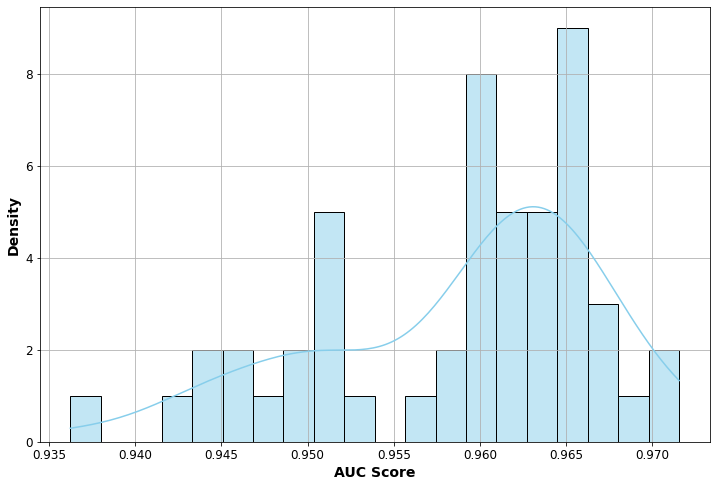

In [58]:
import seaborn as sns

# Plot the distribution with kernel density estimate
plt.figure(figsize=(12, 8))
sns.histplot(df2["Values"], kde=True, bins=20, color='skyblue')
plt.xlabel("AUC Score", fontsize=14,  fontweight='bold')
plt.ylabel("Density", fontsize=14,  fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()